# Script to convert coordinates into a reference that UW can use

A coordinate system that uses a unit length measurement is required. 

This script uses the CRUST1.0 dataset to convert the data into a usable format in Underworld.

The different coordinate systems that can be used can be found [here](https://epsg.io/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import netcdf
import rasterio
import os
from scipy.interpolate import RegularGridInterpolator

%matplotlib inline

In [2]:
"""Need to make this a function built into the Underwater package"""

from Convert_data import transform_coordinates



In [3]:
os.listdir('Example_data')

['79616_Global_Map_Images', '79616_Global_Map_Shapefile', 'CRUST1.0-rho.nc']

# CRUST1.0 example

In [4]:
CRUST1 = netcdf.NetCDFFile('Example_data/'+'CRUST1.0-rho.nc','r')

In [5]:
### grids data
xv, yv = np.meshgrid(CRUST1.variables['longitude'].data, CRUST1.variables['latitude'].data)

### convert dataset
x_new, y_new = transform_coordinates(xv.flatten(), yv.flatten(), 4326, 3857)

### get unique values for new long and lat values, should be in same order as input data
x_unique = np.unique(x_new)
y_unique = np.unique(y_new)


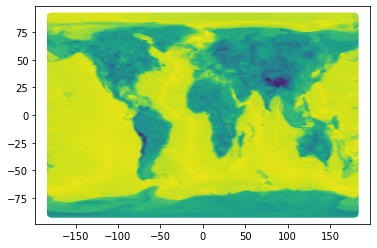

In [6]:
### initial data plot 
plt.scatter(xv.flatten(), yv.flatten(), c=CRUST1.variables['mantle_top'].data.flatten()) 

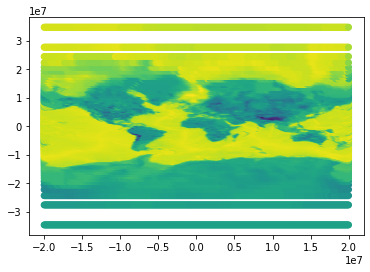

In [7]:
"""
converted data plot to check it looks okay. 
Lots of distortion near pole, as  espg=3857 bounds are up to +-85.06
"""
plt.scatter(x_new, y_new, c=CRUST1.variables['mantle_top'].data.flatten()) 

# Elevation map of Australia example

In [8]:
### use rioxarray to load geotiff files
import rioxarray

In [9]:
with rioxarray.open_rasterio('Example_data/79616_Global_Map_Images/'+'elevation.tif') as data:
    x = data.sel(band=1).x.data
    y = data.sel(band=1).y.data
    z = data.sel(band=1).data
    


In [10]:
# ### grids data
xv, yv = np.meshgrid(x,y)

In [11]:
# ### convert dataset
x_new, y_new = transform_coordinates(xv.flatten(), yv.flatten(), 4326, 28355)

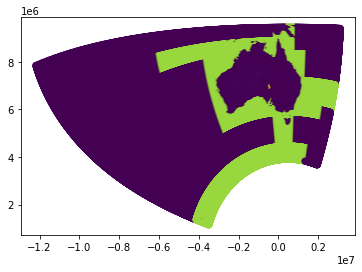

In [12]:
### check data, looks strange.
plt.scatter(x_new[::100], y_new[::100], c=z.flatten()[::100])


In [13]:
# ### retry converting dataset using different coordinate system
x_new, y_new = transform_coordinates(xv.flatten(), yv.flatten(), 4326, 3857)

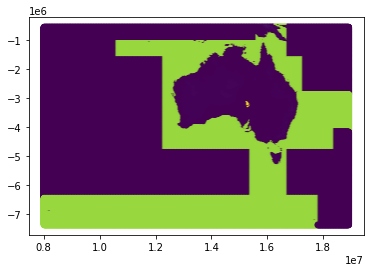

In [26]:
### data looks 'better'
plt.scatter(x_new[::100], y_new[::100], c=z.flatten()[::100])

In [27]:
### these datasets can be imported into Underworld using scipys RegularGridInterpolator
layer_interp = RegularGridInterpolator((np.unique(y_new), np.unique(x_new)), z, bounds_error=False)




In [28]:
### example region in Australia
xmin, xmax, ymin, ymax = 1.4e7, 1.8e7, -5e6, -1e6

x_example = np.arange(xmin, xmax, 5e3)
y_example = np.arange(ymin, ymax, 5e3)

In [29]:
### creates a grid, similar to that used in Underworld 
x_grid, y_grid = np.meshgrid(x_example, y_example)

In [30]:
### produces the expected z values at those points 
example_surface = layer_interp((y_grid.flatten(), x_grid.flatten()))

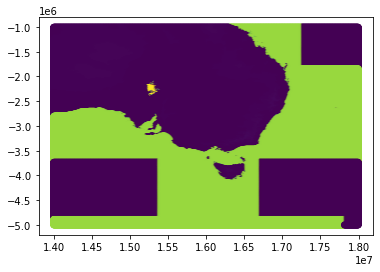

In [31]:
### check data looks okay, y values have been fliped to display data correctly.
plt.scatter(x_grid.flatten(), np.flipud(y_grid.flatten()), c=example_surface)